In [12]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

Load the text extraction data (assuming multiple cluster files) and the video engagement data.

In [22]:
# Specify the folder containing the cluster files
cluster_folder = 'text_clusters'  # Replace with the actual folder path

# List all CSV files in the folder
cluster_files = [os.path.join(cluster_folder, f) for f in os.listdir(cluster_folder) if f.endswith('.csv')]

# Print the list of files to verify
print("Cluster Files Found:")
print(cluster_files)

Cluster Files Found:
['text_clusters\\df_cluster_0.csv', 'text_clusters\\df_cluster_1.csv', 'text_clusters\\df_cluster_2.csv', 'text_clusters\\df_cluster_3.csv', 'text_clusters\\df_cluster_4.csv']


In [24]:
# Combine all cluster data into one DataFrame
text_data = pd.concat([pd.read_csv(file) for file in cluster_files], ignore_index=True)

# Load video engagement data
video_data = pd.read_csv('Final_clustering/Results_Count_Final.csv')

In [25]:
# Display the first few rows of both datasets
print("\nText Extraction Data:")
print(text_data.head())
print("\nNumber of rows and columns in text_data:", text_data.shape)

print("\nVideo Engagement Data:")
print(video_data.head())
print("\nNumber of rows and columns in video_data:", video_data.shape)


Text Extraction Data:
      Video ID text_cleaned  cluster  x0_Bert-CLS  x1_Bert-CLS
0  CUhaitHEAZE          NaN        0    -6.414154    -1.595282
1  MovIpxxyOlo          NaN        0    -6.414154    -1.595282
2  vrwkd3W1lD0          NaN        0    -6.414154    -1.595282
3  6TiMvS0rE2I          NaN        0    -6.414154    -1.595282
4  BUCANbJ9rZs          NaN        0    -6.414154    -1.595282

Number of rows and columns in text_data: (2587, 5)

Video Engagement Data:
       VideoID  View Count  Like Count  Comment Count
0  --8n6A8Q6M0      338385       11044           1371
1  -0FfyNZdHk0         147           4              1
2  -1B7cVoZr1c      150876        3011            225
3  -4yu_13EHFM       28277        1158            381
4  -6FvAU9H98w       63409        1277            110

Number of rows and columns in video_data: (3715, 4)


In [26]:
# Merge datasets on VideoID, renaming 'Video ID' in text_data to match 'VideoID' in video_data
# First rename the column in text_data
text_data = text_data.rename(columns={'Video ID': 'VideoID'})

# Now merge using the consistent column name
merged_data = pd.merge(text_data, video_data, on='VideoID', how='inner')

# Check the merged dataset
print("\nMerged Dataset:")
print(merged_data.head())

# Display the number of rows and columns
print("\nNumber of rows and columns:", merged_data.shape)


Merged Dataset:
       VideoID text_cleaned  cluster  x0_Bert-CLS  x1_Bert-CLS  View Count  \
0  CUhaitHEAZE          NaN        0    -6.414154    -1.595282       45402   
1  MovIpxxyOlo          NaN        0    -6.414154    -1.595282     5532347   
2  vrwkd3W1lD0          NaN        0    -6.414154    -1.595282      691411   
3  6TiMvS0rE2I          NaN        0    -6.414154    -1.595282      134338   
4  BUCANbJ9rZs          NaN        0    -6.414154    -1.595282      588360   

   Like Count  Comment Count  
0        1889            262  
1       83043           6984  
2       31855           2486  
3           0            328  
4       11737            883  

Number of rows and columns: (2568, 8)


## ANOVA Correlation

In [27]:
## ANOVA Analysis for Text Clusters

# Define the metrics we'll analyze
metric_columns = ['View Count', 'Like Count', 'Comment Count']
print(f"Analyzing metrics: {', '.join(metric_columns)}")

# Set significance level
alpha = 0.05

Analyzing metrics: View Count, Like Count, Comment Count


In [28]:
# Function to identify and remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create masks for outliers and non-outliers
    outlier_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    # Return dataframes with and without outliers
    return df[~outlier_mask], df[outlier_mask]

# Create dictionaries to store clean data and outliers
clean_data = {}
outliers = {}

View Count

Outlier Analysis - Views:
Original video count: 2568
After outlier removal: 2224
Videos removed: 344 (13.4%)


C:\Users\yesha\AppData\Local\Temp\ipykernel_88324\2372541207.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='View Count', data=merged_data, ax=ax1, palette='Set2')
C:\Users\yesha\AppData\Local\Temp\ipykernel_88324\2372541207.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], ax=ax2, palette='Set2')


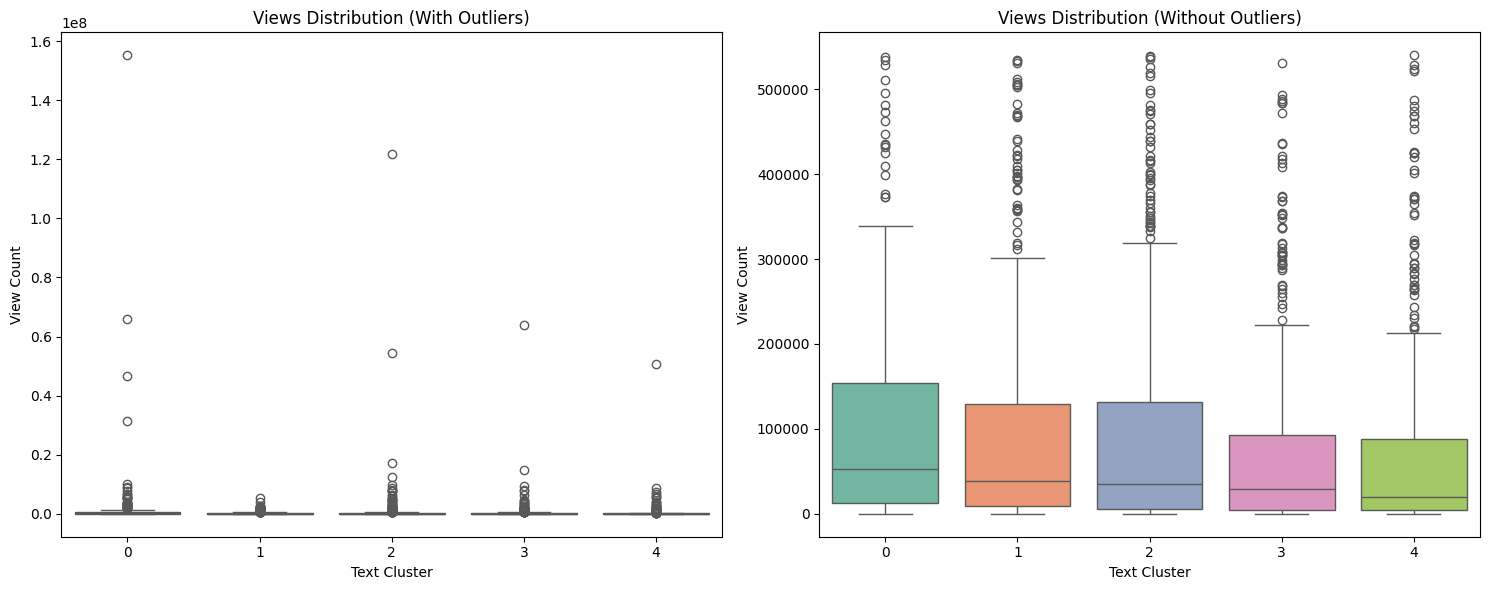

In [29]:
# Remove outliers for View Count
clean_data['View Count'], outliers['View Count'] = remove_outliers(merged_data, 'View Count')

print("Outlier Analysis - Views:")
print(f"Original video count: {merged_data['VideoID'].nunique()}")
print(f"After outlier removal: {clean_data['View Count']['VideoID'].nunique()}")
print(f"Videos removed: {merged_data['VideoID'].nunique() - clean_data['View Count']['VideoID'].nunique()} "
      f"({(merged_data['VideoID'].nunique() - clean_data['View Count']['VideoID'].nunique()) / merged_data['VideoID'].nunique() * 100:.1f}%)")

# Visualize distribution before and after outlier removal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before outlier removal
sns.boxplot(x='cluster', y='View Count', data=merged_data, ax=ax1, palette='Set2')
ax1.set_title('Views Distribution (With Outliers)')
ax1.set_xlabel('Text Cluster')
ax1.set_ylabel('View Count')

# After outlier removal
sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], ax=ax2, palette='Set2')
ax2.set_title('Views Distribution (Without Outliers)')
ax2.set_xlabel('Text Cluster')
ax2.set_ylabel('View Count')

plt.tight_layout()
plt.show()


Number of videos per cluster after outlier removal:
cluster
0    187
1    496
2    729
3    384
4    428
Name: VideoID, dtype: int64


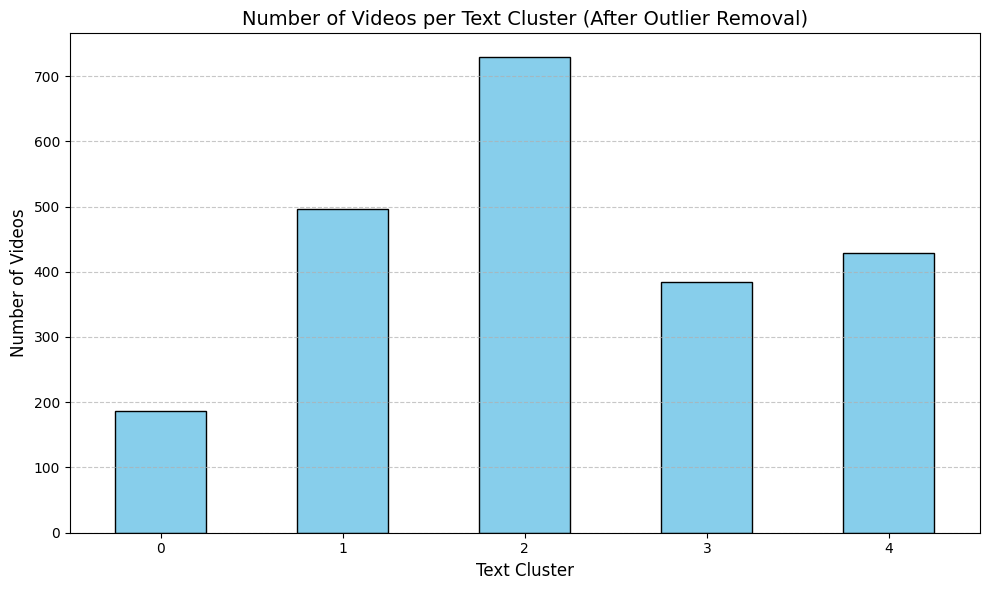

In [30]:
# Count number of videos per cluster after outlier removal
videos_per_cluster = clean_data['View Count'].groupby('cluster')['VideoID'].nunique()

print("\nNumber of videos per cluster after outlier removal:")
print(videos_per_cluster)

# Optional: Plot a bar chart to visualize the number of videos per cluster
plt.figure(figsize=(10, 6))
videos_per_cluster.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Videos per Text Cluster (After Outlier Removal)', fontsize=14)
plt.xlabel('Text Cluster', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Like Count


Outlier Analysis - Likes:
Original data points: 2568
After outlier removal: 2256
Outliers removed: 312 (12.1%)


C:\Users\yesha\AppData\Local\Temp\ipykernel_93840\2246965847.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Like Count', data=merged_data, ax=ax1, palette='Set2')
C:\Users\yesha\AppData\Local\Temp\ipykernel_93840\2246965847.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], ax=ax2, palette='Set2')


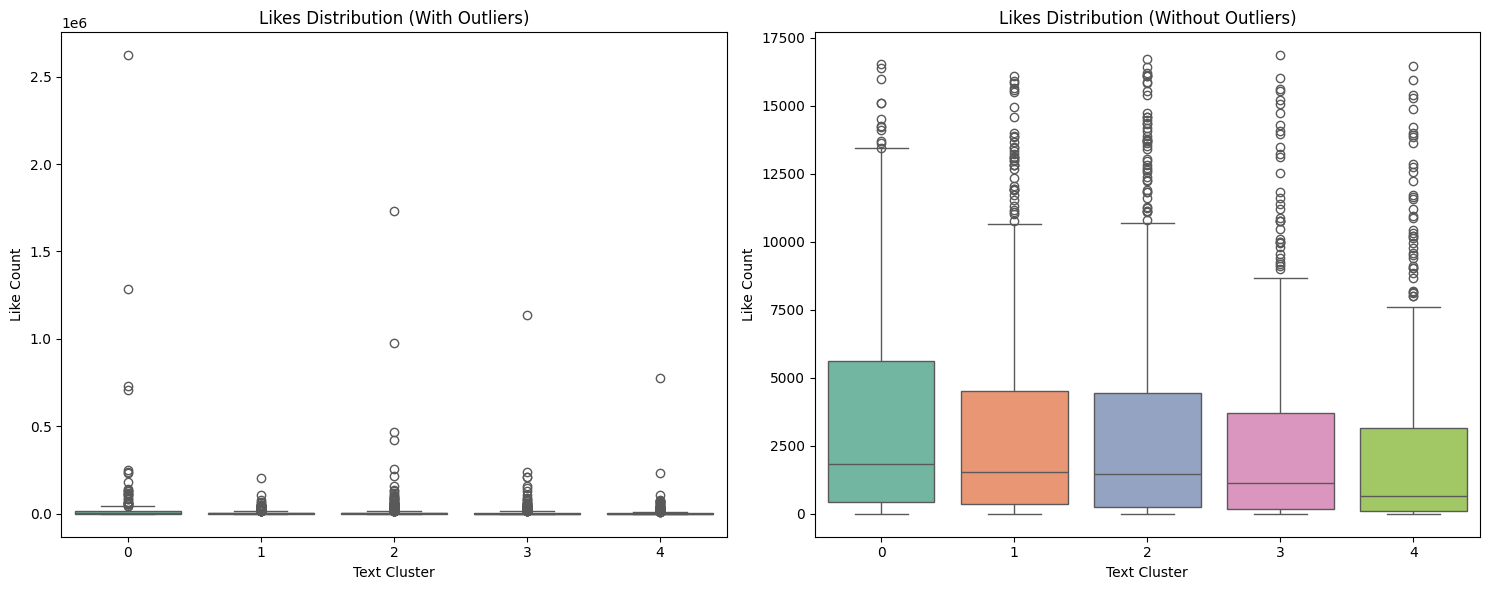

In [19]:
# Remove outliers for Like Count
clean_data['Like Count'], outliers['Like Count'] = remove_outliers(merged_data, 'Like Count')

print("Outlier Analysis - Likes:")
print(f"Original data points: {len(merged_data)}")
print(f"After outlier removal: {len(clean_data['Like Count'])}")
print(f"Outliers removed: {len(outliers['Like Count'])} ({len(outliers['Like Count'])/len(merged_data)*100:.1f}%)")

# Visualize distribution before and after outlier removal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before outlier removal
sns.boxplot(x='cluster', y='Like Count', data=merged_data, ax=ax1, palette='Set2')
ax1.set_title('Likes Distribution (With Outliers)')
ax1.set_xlabel('Text Cluster')
ax1.set_ylabel('Like Count')

# After outlier removal
sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], ax=ax2, palette='Set2')
ax2.set_title('Likes Distribution (Without Outliers)')
ax2.set_xlabel('Text Cluster')
ax2.set_ylabel('Like Count')

plt.tight_layout()
plt.show()

Commetn Count

Outlier Analysis - Comments:
Original data points: 2568
After outlier removal: 2232
Outliers removed: 336 (13.1%)


C:\Users\yesha\AppData\Local\Temp\ipykernel_93840\2573769111.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Comment Count', data=merged_data, ax=ax1, palette='Set2')
C:\Users\yesha\AppData\Local\Temp\ipykernel_93840\2573769111.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], ax=ax2, palette='Set2')


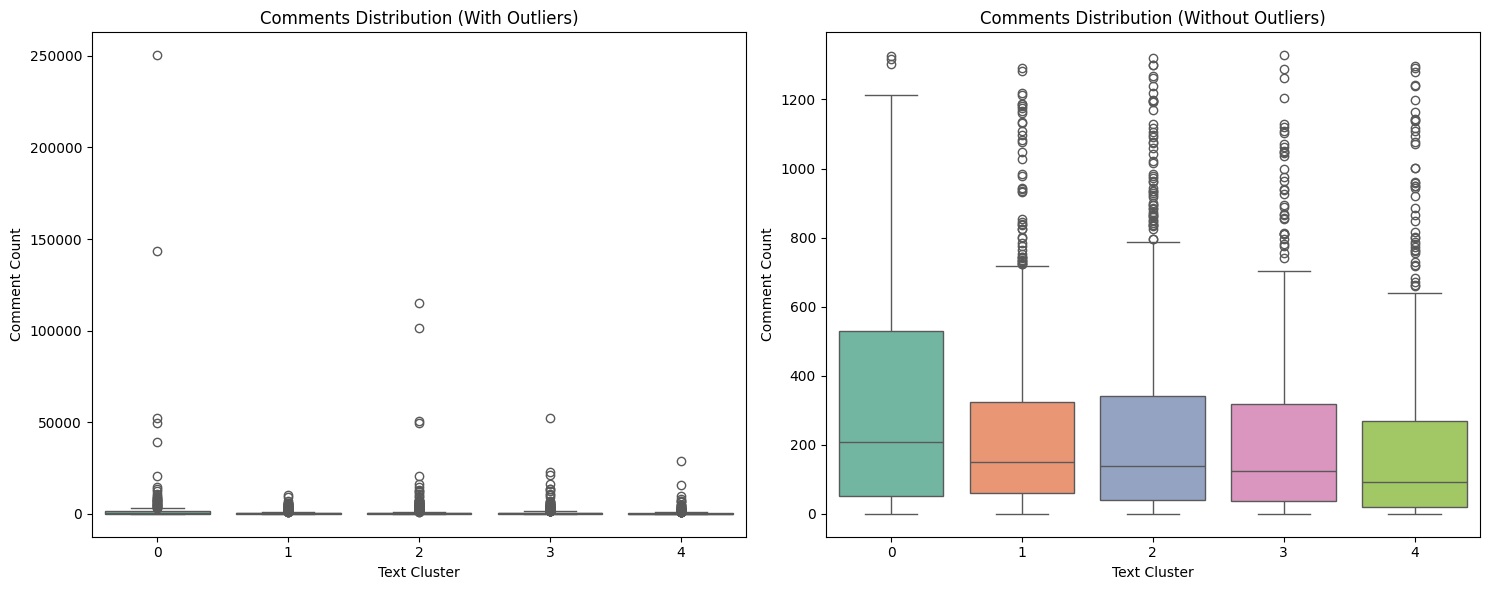

In [20]:
# Remove outliers for Comment Count
clean_data['Comment Count'], outliers['Comment Count'] = remove_outliers(merged_data, 'Comment Count')

print("Outlier Analysis - Comments:")
print(f"Original data points: {len(merged_data)}")
print(f"After outlier removal: {len(clean_data['Comment Count'])}")
print(f"Outliers removed: {len(outliers['Comment Count'])} ({len(outliers['Comment Count'])/len(merged_data)*100:.1f}%)")

# Visualize distribution before and after outlier removal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before outlier removal
sns.boxplot(x='cluster', y='Comment Count', data=merged_data, ax=ax1, palette='Set2')
ax1.set_title('Comments Distribution (With Outliers)')
ax1.set_xlabel('Text Cluster')
ax1.set_ylabel('Comment Count')

# After outlier removal
sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], ax=ax2, palette='Set2')
ax2.set_title('Comments Distribution (Without Outliers)')
ax2.set_xlabel('Text Cluster')
ax2.set_ylabel('Comment Count')

plt.tight_layout()
plt.show()

See all the total of videos per cluster

In [21]:
# Group cleaned data by cluster for ANOVA analysis
views_by_cluster = []
likes_by_cluster = []
comments_by_cluster = []

# Create clusters for ANOVA
for cluster_id in sorted(merged_data['cluster'].unique()):
    # Get data for this cluster with outliers removed
    cluster_views = clean_data['View Count'][clean_data['View Count']['cluster'] == cluster_id]['View Count'].values
    views_by_cluster.append(cluster_views)
    
    cluster_likes = clean_data['Like Count'][clean_data['Like Count']['cluster'] == cluster_id]['Like Count'].values
    likes_by_cluster.append(cluster_likes)
    
    cluster_comments = clean_data['Comment Count'][clean_data['Comment Count']['cluster'] == cluster_id]['Comment Count'].values
    comments_by_cluster.append(cluster_comments)
    
    # Print some info about the data we're using
    print(f"Cluster {cluster_id} (after outlier removal):")
    print(f"  Views: {len(cluster_views)} videos")
    print(f"  Likes: {len(cluster_likes)} videos")
    print(f"  Comments: {len(cluster_comments)} videos")

Cluster 0 (after outlier removal):
  Views: 187 videos
  Likes: 190 videos
  Comments: 193 videos
Cluster 1 (after outlier removal):
  Views: 496 videos
  Likes: 502 videos
  Comments: 493 videos
Cluster 2 (after outlier removal):
  Views: 729 videos
  Likes: 746 videos
  Comments: 733 videos
Cluster 3 (after outlier removal):
  Views: 384 videos
  Likes: 388 videos
  Comments: 381 videos
Cluster 4 (after outlier removal):
  Views: 428 videos
  Likes: 430 videos
  Comments: 432 videos


view count anova

In [22]:
# Perform ANOVA test on Views
anova_views = f_oneway(*views_by_cluster)

print("## ANOVA Results for Views ##")
print(f"F-statistic: {anova_views.statistic:.4f}")
print(f"p-value: {anova_views.pvalue:.4e}")

if anova_views.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in Views across text clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in Views across text clusters (p > {alpha}).")

## ANOVA Results for Views ##
F-statistic: 4.0791
p-value: 2.6845e-03
RESULT: There are statistically significant differences in Views across text clusters (p < 0.05).


C:\Users\yesha\AppData\Local\Temp\ipykernel_93840\4203132139.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], palette='Set2')


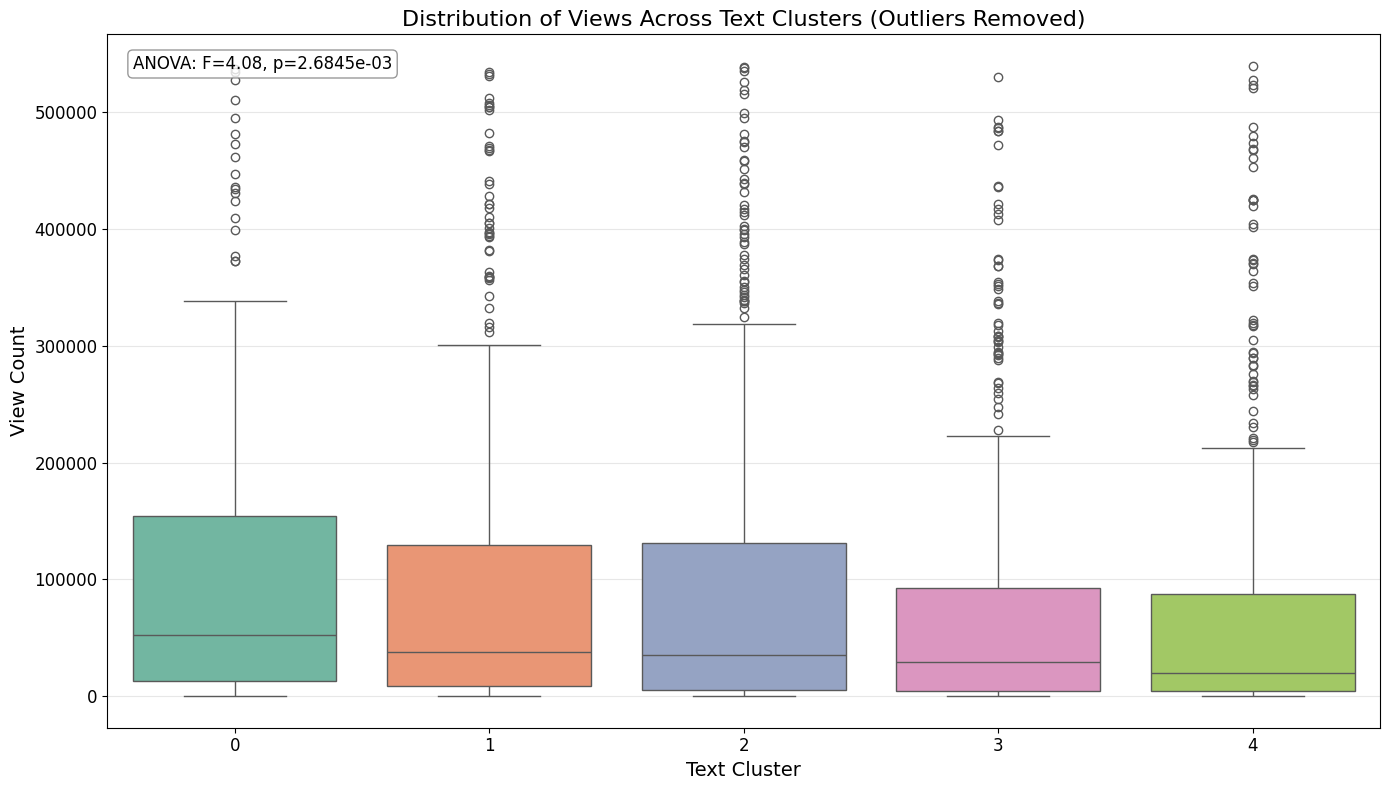

In [23]:
# Create boxplot for Views distribution by cluster
plt.figure(figsize=(14, 8))

# Create the boxplot
sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], palette='Set2')


# Style the plot
plt.title('Distribution of Views Across Text Clusters (Outliers Removed)', fontsize=16)
plt.xlabel('Text Cluster', fontsize=14)
plt.ylabel('View Count', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_views.statistic:.2f}, p={anova_views.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()

Like count anova

In [24]:
# Perform ANOVA test on Likes
anova_likes = f_oneway(*likes_by_cluster)

print("## ANOVA Results for Likes ##")
print(f"F-statistic: {anova_likes.statistic:.4f}")
print(f"p-value: {anova_likes.pvalue:.4e}")

if anova_likes.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in Likes across text clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in Likes across text clusters (p > {alpha}).")

## ANOVA Results for Likes ##
F-statistic: 6.2501
p-value: 5.3345e-05
RESULT: There are statistically significant differences in Likes across text clusters (p < 0.05).


C:\Users\yesha\AppData\Local\Temp\ipykernel_93840\1990300238.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], palette='Set2')


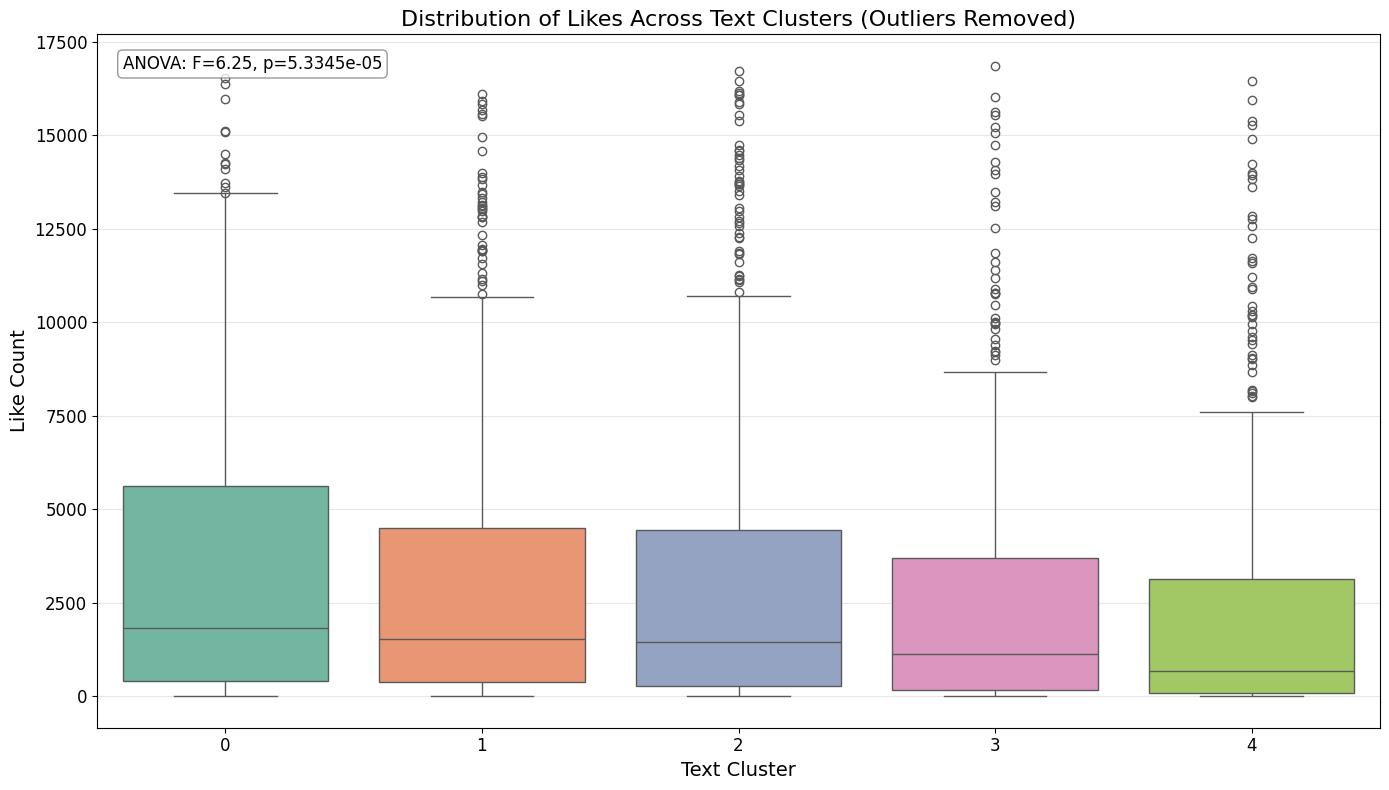

In [25]:
# Create boxplot for Likes distribution by cluster
plt.figure(figsize=(14, 8))

# Create the boxplot
sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], palette='Set2')


# Style the plot
plt.title('Distribution of Likes Across Text Clusters (Outliers Removed)', fontsize=16)
plt.xlabel('Text Cluster', fontsize=14)
plt.ylabel('Like Count', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_likes.statistic:.2f}, p={anova_likes.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()

comment count anova

In [26]:
# Perform ANOVA test on Comments
anova_comments = f_oneway(*comments_by_cluster)

print("## ANOVA Results for Comments ##")
print(f"F-statistic: {anova_comments.statistic:.4f}")
print(f"p-value: {anova_comments.pvalue:.4e}")

if anova_comments.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in Comments across text clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in Comments across text clusters (p > {alpha}).")

## ANOVA Results for Comments ##
F-statistic: 5.0078
p-value: 5.1072e-04
RESULT: There are statistically significant differences in Comments across text clusters (p < 0.05).


C:\Users\yesha\AppData\Local\Temp\ipykernel_93840\1842981975.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], palette='Set2')


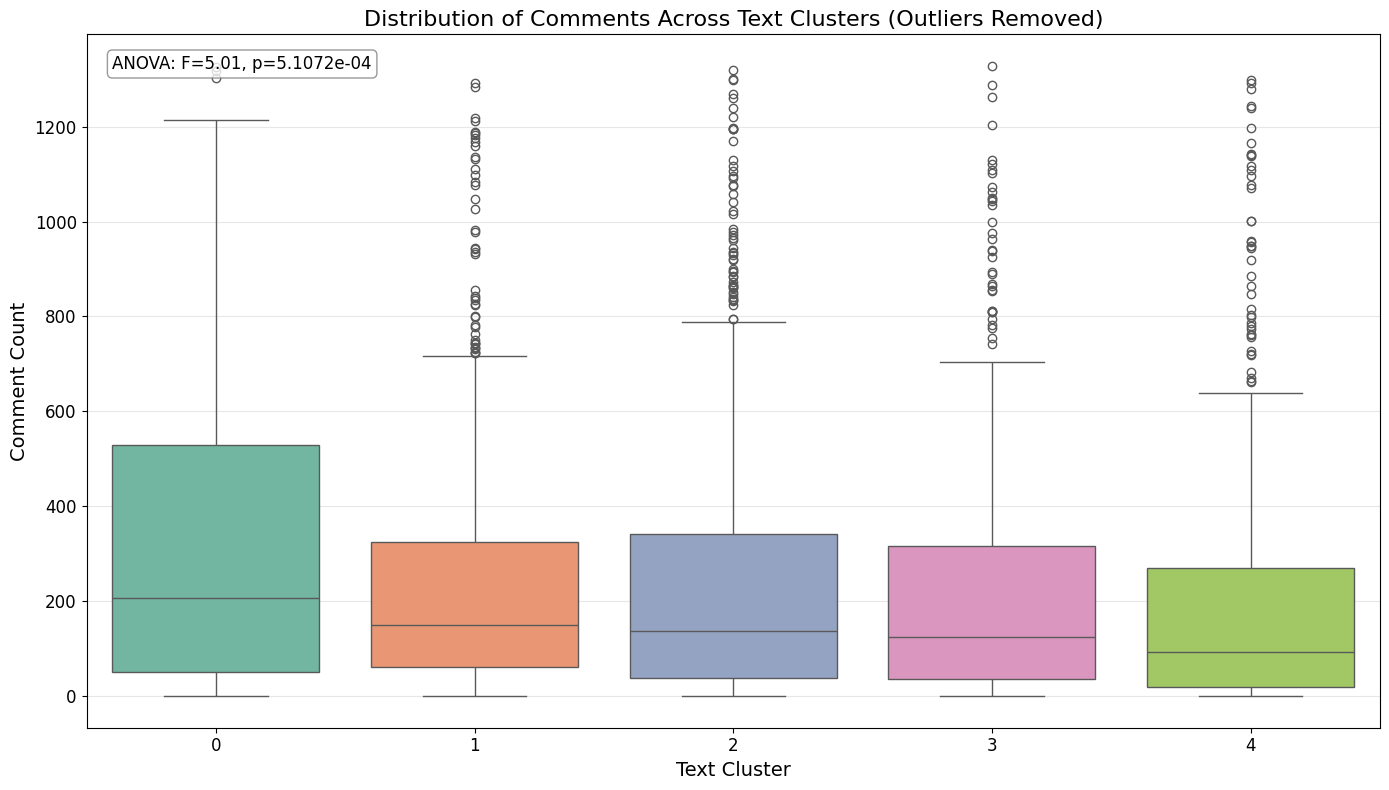

In [27]:
# Create boxplot for Comments distribution by cluster
plt.figure(figsize=(14, 8))

# Create the boxplot
sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], palette='Set2')


# Style the plot
plt.title('Distribution of Comments Across Text Clusters (Outliers Removed)', fontsize=16)
plt.xlabel('Text Cluster', fontsize=14)
plt.ylabel('Comment Count', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_comments.statistic:.2f}, p={anova_comments.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()